In [1]:
from datetime import datetime, timedelta
import pytz
import math
import pylab as plt

import pandas as pd
import numpy as np

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

%load_ext autoreload

%matplotlib widget
from plotter import Plot
from filewriter import ExcelWriter as ex

from extractor import WeatherExtractor, Extractor, Period

from inversegreyboxmodel import Learner

n_std_outliers = 3.0 # default for the multiplier of the the standard deviation; further out than this times the std, outliers are removed during preprocessing
up_intv = '5min' # the default upsampling interval that is used before interpolation is done
gap_n_intv = 11 # the default maximum number of consecutive NaNs to fill(one for each upsampling interval), i.e. valid measurement values (11+1)* 5 min = 1 hour apart apart will be bridget by interpolation, but not more
sampling_interval = '15min' # the default interval on which interpolation will be done during preprocessing
moving_horizon_duration_d = 7
required_columns_for_sanity = ['home_id', 'outdoor_eff_temp_avg_C', 'irradiation_hor_avg_W_per_m2', 'indoor_temp_avg_C', 'gas_sup_avg_W', 'e_remaining_heat_W_avg', 'interval_s']
        

sanity_fraction = 0.5

#location: center of Assendorp neighbourhood in Zwolle
lat, lon = 52.5065500000, 6.0996100000

#timezone: 
timezone_homes = 'Europe/Amsterdam'

# TODO: get list of pseudonyms, (valid) dates and reference parameters from Excel file?  
# utimately: #min, max dates of the analysis
# start = pytz.timezone(timezone_homes).localize(datetime(2021, 10, 21))
# end = pytz.timezone(timezone_homes).localize(datetime(2022, 5, 12))
start = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 3))
end = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 24))

# homes = [803422, 805164, 809743, 811308, 815925, 817341, 822479, 829947, 830088, 831062, 839440, 845966, 845997, 846697, 857477, 864296, 873985, 879481, 881611, 886307, 895671, 897349, 899510]
# reversedhomes = [899510, 897349, 895671, 886307, 881611, 879481, 873985, 864296, 857477, 846697, 845997, 845966, 839440, 831062, 830088, 829947, 822479, 817341, 815925, 811308, 809743, 805164, 803422]
# Optionally: oveerride homes and dates for which to get data
homes =  [886307]
# homes =  [817341, 886307, 873985, 803422, 805164]


In [2]:
#check whether the datetime object is properly timezone-aware
start

datetime.datetime(2022, 1, 3, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)

In [3]:
#check whether the datetime object is properly timezone-aware
end

datetime.datetime(2022, 1, 24, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)

In [4]:
%%time 
%autoreload 2
# get geospatially interpolated weather from KNMI
# for Twomes, the Weather for all all homes studies can be approached by a single location
# get the dataframe only once for all homes to save time

df_weather = WeatherExtractor.get_interpolated_weather_nl(start, end, lat, lon, timezone_homes, sampling_interval)

Resampling weather data...
CPU times: user 42.7 ms, sys: 3.32 ms, total: 46 ms
Wall time: 44.8 ms


In [5]:
df_weather

,outdoor_temp_avg_C,wind_m_per_s_avg,irradiation_hor_avg_W_per_m2,outdoor_eff_temp_avg_C
2022-01-03 00:00:00+01:00,9.972115,8.149020,0.0,4.539434
2022-01-03 00:15:00+01:00,9.922115,8.084107,0.0,4.532710
2022-01-03 00:30:00+01:00,9.872115,8.019193,0.0,4.525986
2022-01-03 00:45:00+01:00,9.822115,7.954279,0.0,4.519262
2022-01-03 01:00:00+01:00,9.762231,7.911003,0.0,4.488228
...,...,...,...,...
2022-01-23 22:45:00+01:00,5.068671,1.330762,0.0,4.181497
2022-01-23 23:00:00+01:00,5.030462,1.337873,0.0,4.138547
2022-01-23 23:15:00+01:00,5.018353,1.316541,0.0,4.140659
2022-01-23 23:30:00+01:00,5.006244,1.295208,0.0,4.142772


In [6]:
#see more statisctics about the weather data
df_weather.describe(include='all')

,outdoor_temp_avg_C,wind_m_per_s_avg,irradiation_hor_avg_W_per_m2,outdoor_eff_temp_avg_C
count,2016.000000,2016.000000,2016.000000,2016.000000
mean,4.343867,3.396172,23.260891,2.079753
std,2.314392,1.613092,45.273682,2.120560
min,-1.502947,0.399568,0.000000,-3.430126
25%,2.997746,2.170658,0.000000,0.377112
50%,4.548167,3.276362,0.000000,2.202611
75%,5.774164,4.400526,27.593609,3.672000
max,10.933505,8.682856,249.723378,6.162751


In [7]:
%%time 
# get interpolated data from the Twomes database and combine with weather data already obtained

df_data_homes = Extractor.get_preprocessed_homes_data(homes, start, end, timezone_homes,
                                                      up_intv, gap_n_intv, sampling_interval, 
                                                      required_columns_for_sanity,
                                                      df_weather)

Retrieving data for homes [886307] from 2022-01-03T00:00:00+01:00 to 2022-01-24T00:00:00+01:00 ...


  0%|          | 0/1 [00:00<?, ?it/s]

gas_no_CH_avg_m3_per_s: 1.07423E-05
gas_no_CH_sup_avg_W:  377.805346414176
gas_sup_home_avg_W:  892.3615063182708
uncorrected_gas_CH_sup_home_avg_W:  838.6651346174525
scaling_factor:  0.613541852003665
corrected_gas_CH_sup_home_avg_W:  514.5561599040942
gas_no_CH_sup_avg_W + corrected_gas_CH_sup_home_avg_W):  892.3615063182701
CPU times: user 380 ms, sys: 16.6 ms, total: 397 ms
Wall time: 57.4 s


In [8]:
df_data_homes

outdoor_temp_avg_C  wind_m_per_s_avg  \
home_id timestamp                                                         
NaN     2022-01-02 01:00:00+01:00                 NaN               NaN   
        2022-01-02 01:15:00+01:00                 NaN               NaN   
        2022-01-02 01:30:00+01:00                 NaN               NaN   
        2022-01-02 01:45:00+01:00                 NaN               NaN   
        2022-01-02 02:00:00+01:00                 NaN               NaN   
...                                               ...               ...   
        2022-01-24 23:45:00+01:00                 NaN               NaN   
        2022-01-25 00:00:00+01:00                 NaN               NaN   
        2022-01-25 00:15:00+01:00                 NaN               NaN   
        2022-01-25 00:30:00+01:00                 NaN               NaN   
        2022-01-25 00:45:00+01:00                 NaN               NaN   

                                   irradiation_hor_avg_W_per_m2  \
home_id timestamp                                                 
NaN     2022-01-02 01:00:00+01:00                           NaN   
        2022-01-02 01:15:00+01:00                           NaN   
        2022-01-02 01:30:00+01:00                           NaN   
        2022-01-02 01:45:00+01:00                           NaN   
        2022-01-02 02:00:00+01:00                           NaN   
...                                                         ...   
        2022-01-24 23:45:00+01:00                           NaN   
        2022-01-25 00:00:00+01:00                           NaN   
        2022-01-25 00:15:00+01:00                           NaN   
        2022-01-25 00:30:00+01:00                           NaN   
        2022-01-25 00:45:00+01:00                           NaN   

                                   outdoor_eff_temp_avg_C  indoor_temp_avg_C  \
home_id timestamp                                                              
NaN     2022-01-02 01:00:00+01:00                     NaN          17.420000   
        2022-01-02 01:15:00+01:00                     NaN          17.373333   
        2022-01-02 01:30:00+01:00                     NaN          17.293333   
        2022-01-02 01:45:00+01:00                     NaN          17.236667   
        2022-01-02 02:00:00+01:00                     NaN          17.220000   
...                                                   ...                ...   
        2022-01-24 23:45:00+01:00                     NaN          16.640000   
        2022-01-25 00:00:00+01:00                     NaN          16.511667   
        2022-01-25 00:15:00+01:00                     NaN          16.421667   
        2022-01-25 00:30:00+01:00                     NaN          16.350000   
        2022-01-25 00:45:00+01:00                     NaN          16.246667   

                                   setpoint_temp_first_C  gas_m3_cum  \
home_id timestamp                                                      
NaN     2022-01-02 01:00:00+01:00                   13.0    2514.783   
        2022-01-02 01:15:00+01:00                   13.0    2514.783   
        2022-01-02 01:30:00+01:00                   13.0    2514.783   
        2022-01-02 01:45:00+01:00                   13.0    2514.783   
        2022-01-02 02:00:00+01:00                   13.0    2514.783   
...                                                  ...         ...   
        2022-01-24 23:45:00+01:00                   12.5    2564.051   
        2022-01-25 00:00:00+01:00                   12.5    2564.051   
        2022-01-25 00:15:00+01:00                   12.5    2564.051   
        2022-01-25 00:30:00+01:00                   12.5    2564.051   
        2022-01-25 00:45:00+01:00                   12.5    2564.051   

                                   interval_s  gas_sup_avg_W  \
home_id timestamp                                              
NaN     2022-01-02 01:00:00+01:00       900.0            0.0   
        2022-01-0

In [9]:
#see more statisctics
df_data_homes.describe(include='all')

,outdoor_temp_avg_C,wind_m_per_s_avg,irradiation_hor_avg_W_per_m2,outdoor_eff_temp_avg_C,indoor_temp_avg_C,setpoint_temp_first_C,gas_m3_cum,interval_s,gas_sup_avg_W,gas_no_CH_sup_avg_W,gas_CH_sup_avg_W,e_remaining_heat_W_avg,sanity_frac
count,2016.000000,2016.000000,2016.000000,2016.000000,2208.000000,2208.000000,2208.000000,2207.0,2207.000000,2.208000e+03,2207.000000,2207.000000,2208.000000
mean,4.343867,3.396172,23.260891,2.079753,16.692475,14.946321,2538.248330,900.0,892.361506,3.778053e+02,514.556160,134.340734,0.913043
std,2.314392,1.613092,45.273682,2.120560,1.261241,2.303707,14.835320,0.0,2936.727088,8.812726e-12,1742.227430,235.890180,0.281835
min,-1.502947,0.399568,0.000000,-3.430126,13.455000,0.000000,2514.783000,900.0,0.000000,3.778053e+02,0.000000,24.000000,0.000000
25%,2.997746,2.170658,0.000000,0.377112,15.803333,12.500000,2524.546500,900.0,0.000000,3.778053e+02,0.000000,32.000000,1.000000
50%,4.548167,3.276362,0.000000,2.202611,16.756667,15.500000,2538.874333,900.0,0.000000,3.778053e+02,0.000000,68.000000,1.000000
75%,5.774164,4.400526,27.593609,3.672000,17.596667,17.000000,2550.090000,900.0,0.000000,3.778053e+02,0.000000,124.000000,1.000000
max,10.933505,8.682856,249.723378,6.162751,21.126667,22.666667,2564.051000,900.0,22196.177778,3.778053e+02,13386.484629,2708.000000,1.000000


In [10]:
# dfm = pd.DataFrame()
# dfm = df_data_homes.copy()
# dfm.reset_index(inplace=True)
# for col in (dfm.select_dtypes(['datetimetz']).columns):
#     dfm[col] = dfm[col].dt.tz_localize(None)

In [11]:
# dfm

In [12]:
# dfm.loc[886307]

In [13]:
# present some sanity metrics for the extracted data
total_measurement_time = timedelta(seconds = df_data_homes['interval_s'].sum())
print('Total measurement time: ', total_measurement_time)
sane_fraction = df_data_homes['sanity_frac'].mean()
print('Sane fraction measurement time: {:.2f}'.format(sane_fraction))
sane_measurement_time = total_measurement_time * sane_fraction
print('Sane  measurement time: ', sane_measurement_time)

Total measurement time:  22 days, 23:45:00
Sane fraction measurement time: 0.91
Sane  measurement time:  20 days, 23:46:18.260870


In [14]:
%%time 
%autoreload 2

filename_prefix = datetime.now().astimezone(pytz.timezone('Europe/Amsterdam')).replace(microsecond=0).isoformat().replace(":","")
ex.write(df_data_homes, str('{0}-data_homes-{1}-{2}.xlsx'.format(filename_prefix, start.isoformat(),end.isoformat())))

CPU times: user 1.73 s, sys: 45.5 ms, total: 1.77 s
Wall time: 1.77 s


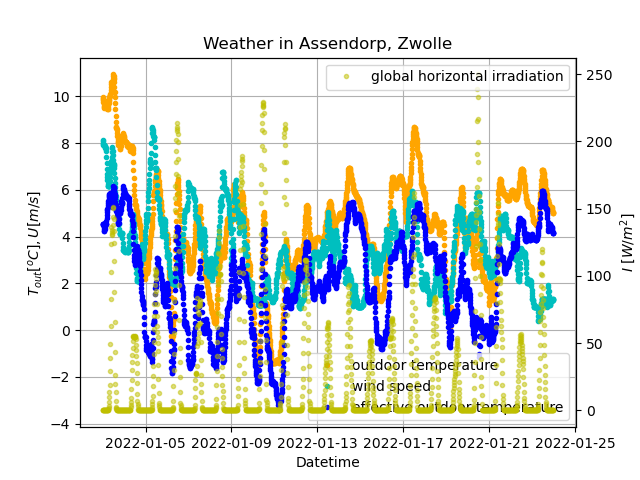

In [15]:
# plot temperature data

Plot.weather_and_other_temperatures('Weather in Assendorp, Zwolle', df_weather)

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [16]:
# how to select data from a single home
# df_data_homes.loc[817341]

In [ ]:
%%time 
%autoreload 2

# homes with most data
# homes_to_analyse = [886307, 873985, 817341]
# start_analysis_period = pytz.timezone(timezone_homes).localize(datetime(2021, 12, 20))
# end_analysis_period = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 18))
# date and times of seemingly valid periods for short set of 3 
# 886307	2021-12-19 18:55	2022-03-17 09:37
# 873985	2021-12-20 12:54	2022-03-17 17:54
# 817341	2022-01-14 20:27	2022-03-17 18:15
    
sanity_fraction_analysis = sanity_fraction

# Use one of the lines below to set the moving horizon duration used for analysis 
# moving_horizon_duration_d_analysis = 4
moving_horizon_duration_d_analysis = moving_horizon_duration_d

# learn the model parameters and write rerults an intermediate results to excel files
df_results = Learner.learn_home_parameter_moving_horizon(df_data_homes, 
                                                         n_std_outliers, up_intv, gap_n_intv, sampling_interval, 
                                                         moving_horizon_duration_d_analysis, sanity_fraction_analysis,
                                                         homes, start, end, 
                                                         showdetails=True, hint_A_m2=6.0)

Homes to analyse:  [886307]
Start of analyses:  2022-01-03 00:00:00+01:00
End of analyses:  2022-01-24 00:00:00+01:00
Moving horizon:  7D
#standard deviations for outlier removal:  3.0
Upsampling_interval:  5min
#upsampling intervals bridged during interpolation (max):  11
Interpolation interval:  15min
Hint for effective window are A [m^2]:  6.0
Hint for superior heating efficiency eta [-]:  0.9


  0%|          | 0/1 [00:00<?, ?it/s]

Home pseudonym:  886307


  0%|          | 0/3 [00:00<?, ?it/s]

Start datetime:  2022-01-03 00:00:00+01:00
End datetime:  2022-01-10 00:00:00+01:00
Sanity 1.00 for home 886307 in period from 2022-01-03 00:00:00+01:00 to 2022-01-10 00:00:00+01:00 higher than 0.50; sufficient for analysis...
                           outdoor_temp_avg_C  wind_m_per_s_avg  \
timestamp                                                         
2022-01-03 00:00:00+01:00            9.972115          8.149020   
2022-01-03 00:15:00+01:00            9.922115          8.084107   
2022-01-03 00:30:00+01:00            9.872115          8.019193   
2022-01-03 00:45:00+01:00            9.822115          7.954279   
2022-01-03 01:00:00+01:00            9.762231          7.911003   
...                                       ...               ...   
2022-01-09 23:00:00+01:00            0.990524          1.945415   
2022-01-09 23:15:00+01:00            0.982193          1.781661   
2022-01-09 23:30:00+01:00            0.973863          1.617907   
2022-01-09 23:45:00+01:00           

In [ ]:
#show the results
df_results

In [ ]:
df_data_homes

In [ ]:
# plot temperature data of multiple homes from an array 
# %autoreload 2
for home_id in homes_to_analyze:
    df_data_one_home = df_data_homes.loc[home_id]
    Plot.weather_and_other_temperatures(home_id, df_data_one_home, [('indoor_temp_degC','r'),('indoor_setpoint_temp_degC','g')])

# # N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks


In [ ]:
#plot a series of weeks for all homes
# plt.ioff()

# for home_id in homes_to_analyze:
#     df_data_one_home = df_data_homes.loc[home_id]
#     for moving_horizon_start in pd.date_range(start=start, end=end, inclusive='left', freq='7D'):
#         moving_horizon_end = min(end, moving_horizon_start + timedelta(days=7))
#         df_moving_horizon = df_data_one_home[moving_horizon_start:moving_horizon_end]
#         Plot.weather_and_other_temperatures(home_id, df_moving_horizon, ['indoor_temp_degC'])

# plt.ion()  
    